In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [22]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]

spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [82]:
sigma = 0.01

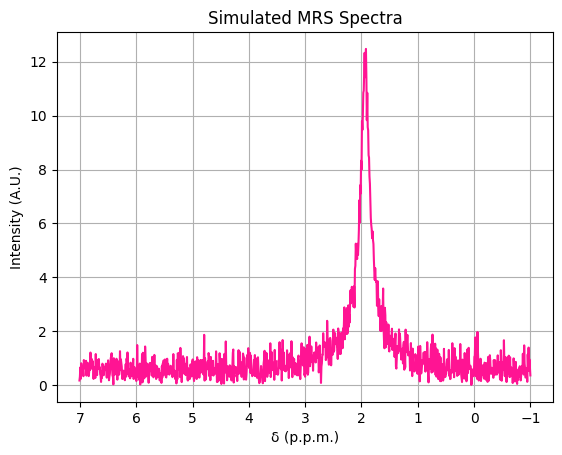

In [84]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

c_sig = pymri.corrupted_snr(sig, 0.0, sigma)
c_freqs, c_sig_fft = pymri.fourier_spectrum( c_sig, dt, B0 )

pymri.plot_chem_shifts( freqs, c_sig_fft, 1.0 )

In [85]:
L = 0.4
noise_threshold = 1e-30

In [86]:
reconstructed_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True)

In [87]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2 = 1/alpha

In [99]:
n_comp = 10

sort_arr = np.argsort(s0)
s0_ = s0[sort_arr]
phi_ = phi[sort_arr]
omega_ = omega[sort_arr]
t2_ = t2[sort_arr]

s0_ = s0_[s0.size - n_comp:]
phi_ = phi_[phi.size - n_comp:]
omega_ = omega_[omega.size - n_comp:]
t2_ = t2_[t2.size - n_comp:]

print(t2_.size)

10


In [100]:
individual_sigs = np.zeros((n_comp, sig.size), dtype=np.complex128)

sig_fft_i = np.zeros((n_comp, sig_fft.size), dtype=np.complex128)
freqs_i = np.zeros((n_comp, freqs.size))

In [101]:
for i in range(n_comp):
    pop = pymri.population(np.array([omega_[i]]), np.array([t2_[i]]), np.array([s0_[i]]), np.array([phi_[i]]))
    individual_sigs[i] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]
    freqs_i[i], sig_fft_i[i] = pymri.fourier_spectrum( individual_sigs[i], dt, B0)
    

In [102]:
final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

In [107]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS)

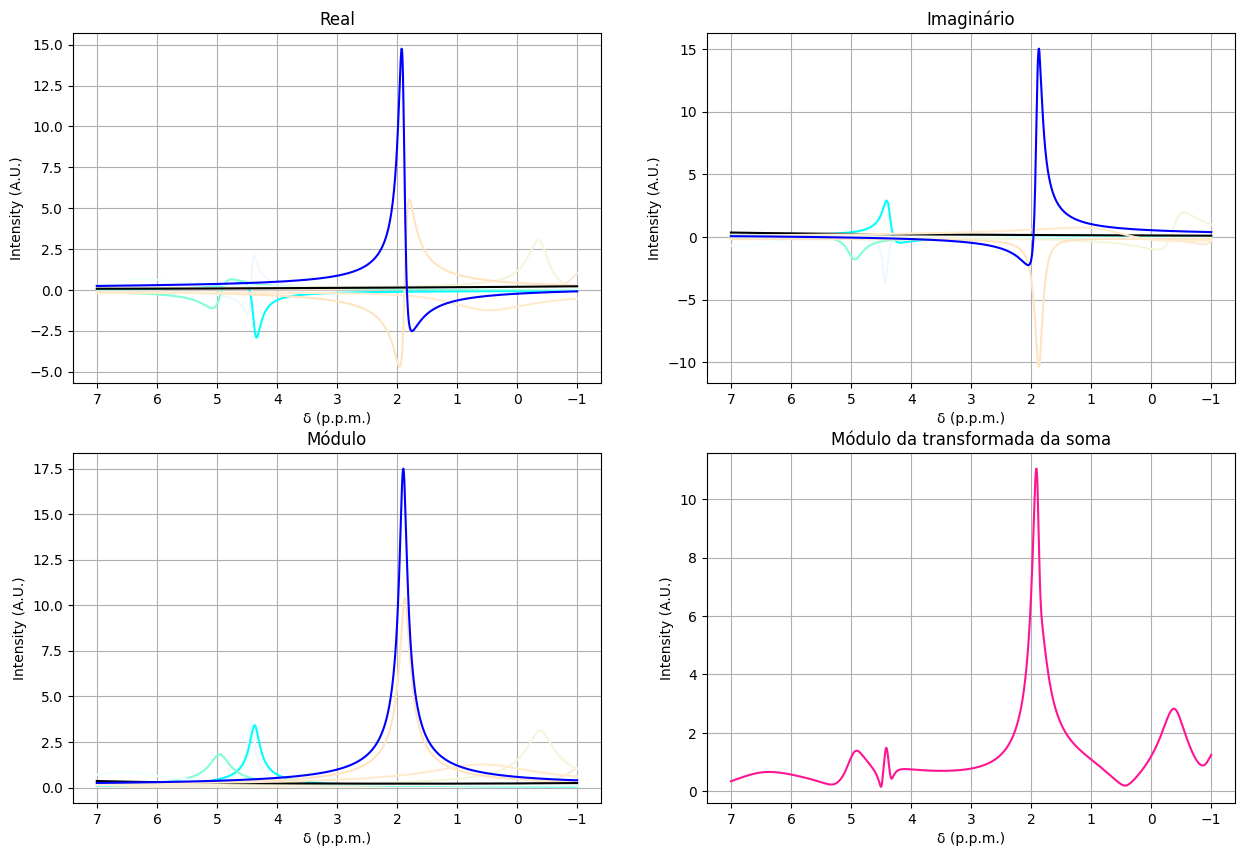

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = colors[i], plot_type="real", title= "Real")

plt.subplot(222)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = colors[i], plot_type="imag", title="Imaginário")

plt.subplot(223)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = colors[i], plot_type="abs", title="Módulo")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = "Módulo da transformada da soma")